In [44]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})  # Replace 14 with your desired font size
plt.rcParams.update({'axes.titlesize': 20})  # Replace 14 with your desired font size
plt.rcParams.update({'axes.titleweight': 'bold'})
plt.rcParams.update({'lines.linewidth': 4})  # Replace 2 with your desired line width
plt.rcParams.update({'figure.figsize': (8, 6)})  # Width = 10, Height = 6 inches



In [45]:
df = pd.read_csv('raw_data/vllm_benchmark_results_A40.csv')

numerical_cols = ['num_speculative_tokens', 'num_requests', 'batch_size', 'latency',
                  'output_token_throughput', 'total_token_throughput', 'sequence_throughput']

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [46]:
# Identify the unique num_speculative_tokens values, excluding 0
unique_tokens = df['num_speculative_tokens'].unique()
unique_tokens = unique_tokens[unique_tokens != 0]  # Exclude 0
unique_tokens.sort()

# Extract baseline data where num_speculative_tokens == 0
baseline_data = df[(df['speculative_model'] == 'None') & (df['num_speculative_tokens'] == 0)]

# Remove baseline data from the main DataFrame
df = df[~((df['speculative_model'] == 'None') & (df['num_speculative_tokens'] == 0))]

# Replicate baseline data across num_speculative_tokens values of 1, 3, 5, and 10
baseline_replicated = pd.DataFrame()

for token in unique_tokens:
    temp = baseline_data.copy()
    temp['num_speculative_tokens'] = token
    baseline_replicated = pd.concat([baseline_replicated, temp], ignore_index=True)

# Combine the adjusted baseline data back into the main DataFrame
df = pd.concat([df, baseline_replicated], ignore_index=True)

In [47]:
# Print available values for each parameter
print("Available values for 'speculative_model':")
print(df['speculative_model'].unique())

print("\nAvailable values for 'num_speculative_tokens':")
print(sorted(df['num_speculative_tokens'].unique()))

print("\nAvailable values for 'num_requests':")
print(sorted(df['num_requests'].unique()))

print("\nAvailable values for 'batch_size':")
print(sorted(df['batch_size'].unique()))

print("\nAvailable values for 'GPU':")
print(df['GPU'].unique())

Available values for 'speculative_model':
['[ngram]' 'facebook/opt-125m' 'facebook/opt-350m' 'None']

Available values for 'num_speculative_tokens':
[1, 3, 5, 10]

Available values for 'num_requests':
[32, 128, 512]

Available values for 'batch_size':
[1, 4, 8, 16, 256]

Available values for 'GPU':


KeyError: 'GPU'

In [ ]:
def plot_relationship(df, fixed_params, x_var, y_var, hue_var=None, plot_type='line', title=None):
    """
    Plots the relationship between x_var and y_var, while fixing other variables.

    Parameters:
    - df: The DataFrame containing the data.
    - fixed_params: Dictionary of variables to fix, e.g., {'num_requests': 32, 'batch_size': 1}
    - x_var: Variable for the x-axis.
    - y_var: Variable for the y-axis.
    - hue_var: Variable for color encoding (optional).
    - plot_type: Type of plot ('line', 'bar', 'scatter', etc.).
    - title: Title of the plot (optional).
    """
    # Filter the DataFrame based on fixed_params
    df_filtered = df.copy()
    for key, value in fixed_params.items():
        df_filtered = df_filtered[df_filtered[key] == value]
    
    # Check if the filtered DataFrame is not empty
    if df_filtered.empty:
        print("No data available for the given fixed parameters.")
        return
    
    # Set the plot style
    sns.set_style('whitegrid')
    
    if plot_type == 'line':
        sns.lineplot(data=df_filtered, x=x_var, y=y_var, hue=hue_var, marker='o')
    elif plot_type == 'bar':
        sns.barplot(data=df_filtered, x=x_var, y=y_var, hue=hue_var)
    elif plot_type == 'scatter':
        sns.scatterplot(data=df_filtered, x=x_var, y=y_var, hue=hue_var)
    else:
        print("Unsupported plot type. Choose from 'line', 'bar', or 'scatter'.")
        return
    
    # Set plot title and labels
    plt.title(title)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    # if hue_var:
        # plt.legend(title=hue_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

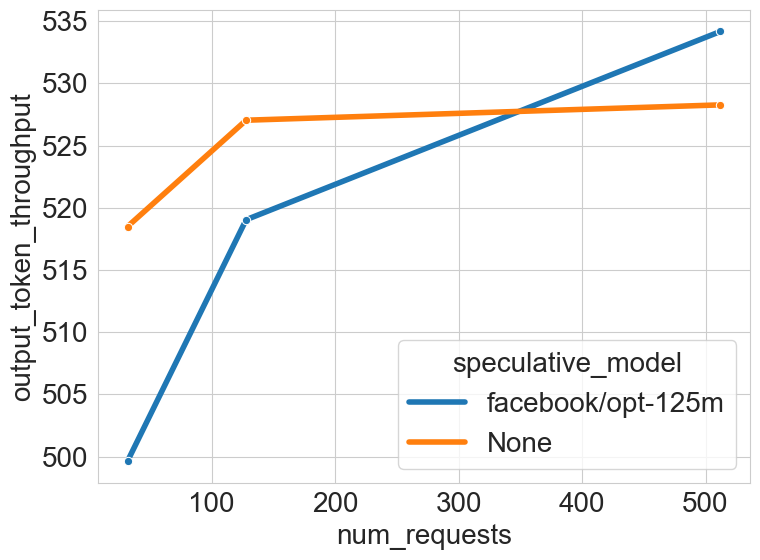

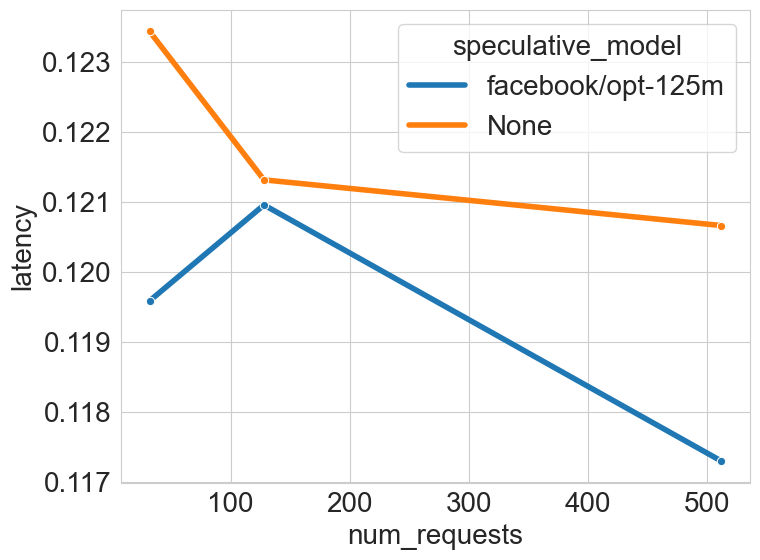

In [ ]:
fixed_params = {'num_speculative_tokens': 3, 'batch_size': 4, 'GPU': 'A40'}
new_df = df[(df['speculative_model'] == 'None') | (df['speculative_model'] == 'facebook/opt-125m')]

plot_relationship(
    df=new_df,
    fixed_params=fixed_params,
    x_var='num_requests',
    y_var='output_token_throughput',
    hue_var='speculative_model',
    plot_type='line',
    # title='Throughput vs. Number of Request'
)

plot_relationship(
    df=new_df,
    fixed_params=fixed_params,
    x_var='num_requests',
    y_var='latency',
    hue_var='speculative_model',
    plot_type='line',
    # title='Latency vs. Number of Request'
)


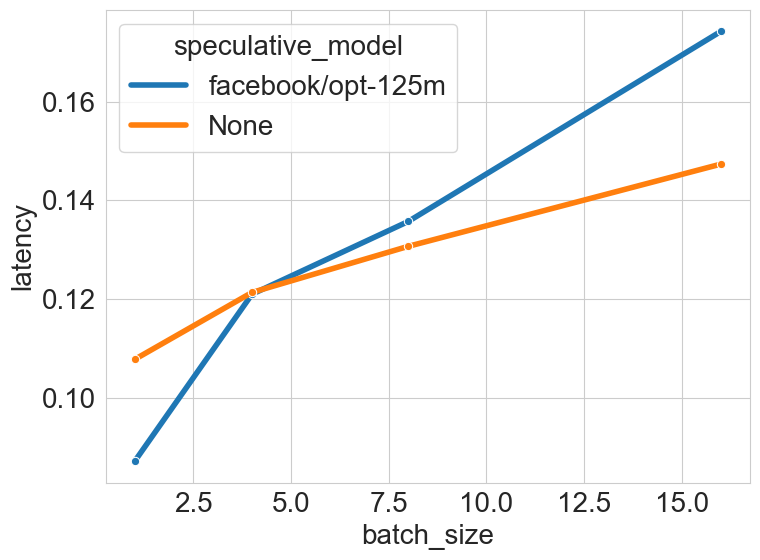

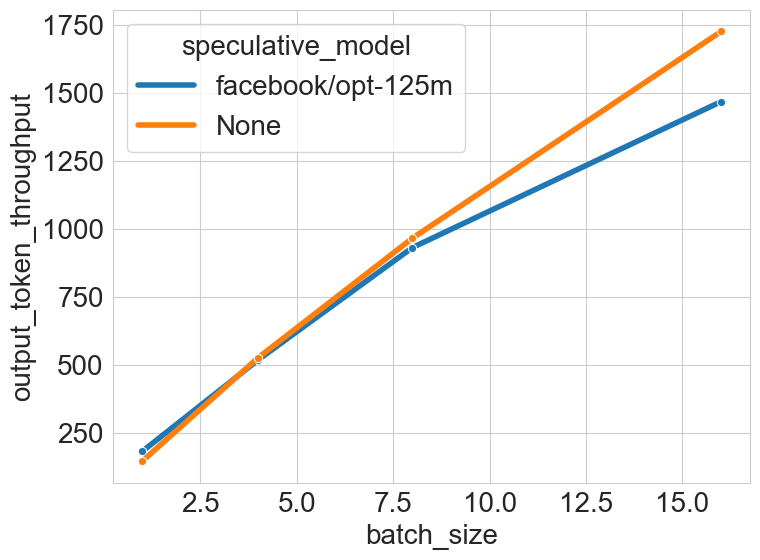

In [ ]:
fixed_params = {'num_speculative_tokens': 3, 'num_requests': 128, 'GPU': 'A40'}
df_new = df[(df['batch_size'] <= 32) & ((df['speculative_model'] == 'None') | (df['speculative_model'] == 'facebook/opt-125m'))]

plot_relationship(
    df=df_new,
    fixed_params=fixed_params,
    x_var='batch_size',
    y_var='latency', # latency   output_token_throughput  total_token_throughput  sequence_throughput
    hue_var='speculative_model',
    plot_type='line',
)

plot_relationship(
    df=df_new,
    fixed_params=fixed_params,
    x_var='batch_size',
    y_var='output_token_throughput', # latency   output_token_throughput  total_token_throughput  sequence_throughput
    hue_var='speculative_model',
    plot_type='line',
)

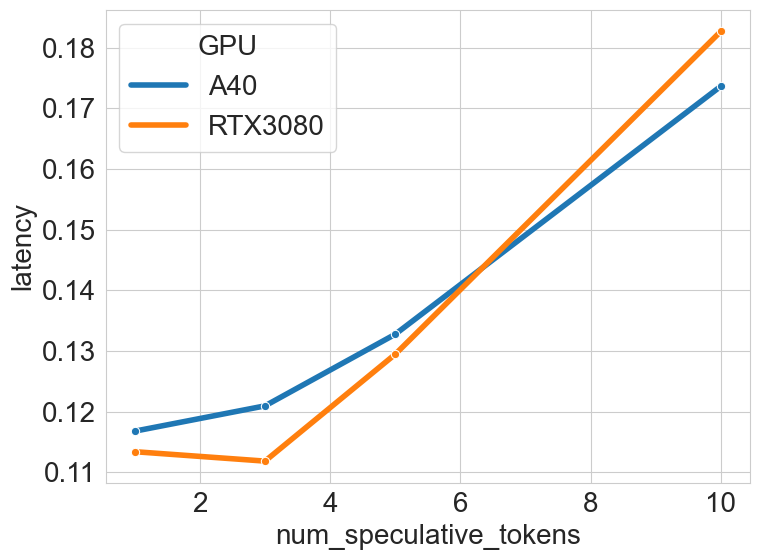

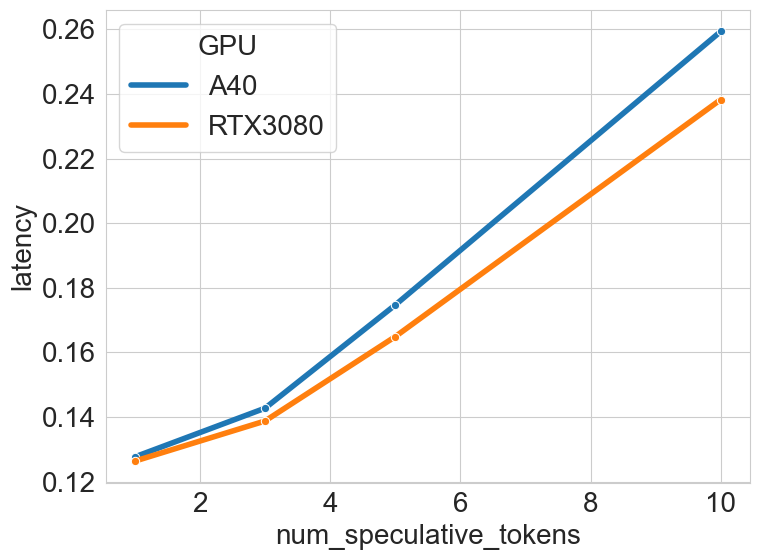

In [ ]:
fixed_params = {'batch_size': 4, 'num_requests': 128, 'speculative_model': 'facebook/opt-125m'}
df_new = df[df['batch_size'] <= 32]
plot_relationship(
    df=df_new,
    fixed_params=fixed_params, 
    x_var='num_speculative_tokens',
    y_var='latency', # latency   output_token_throughput  total_token_throughput  sequence_throughput
    hue_var='GPU',
    plot_type='line',
)

fixed_params = {'batch_size': 4, 'num_requests': 128, 'speculative_model': 'facebook/opt-350m'}
df_new = df[df['batch_size'] <= 32]
plot_relationship(
    df=df_new,
    fixed_params=fixed_params, 
    x_var='num_speculative_tokens',
    y_var='latency', # latency   output_token_throughput  total_token_throughput  sequence_throughput
    hue_var='GPU',
    plot_type='line',
)

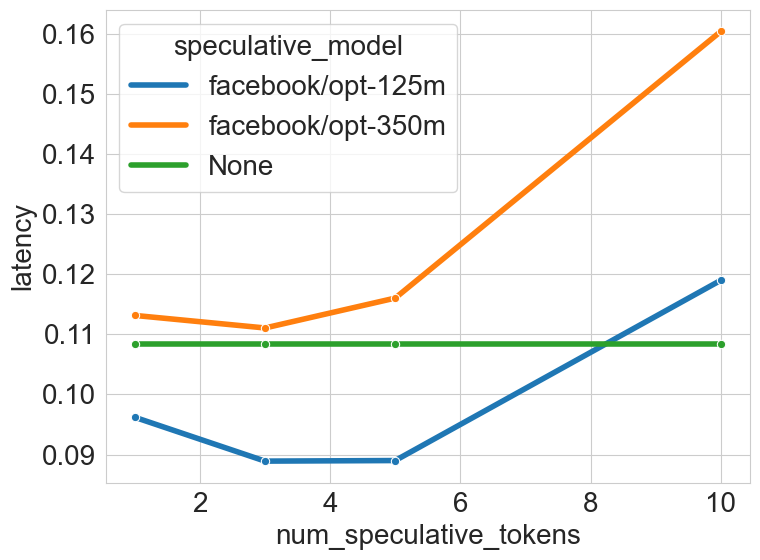

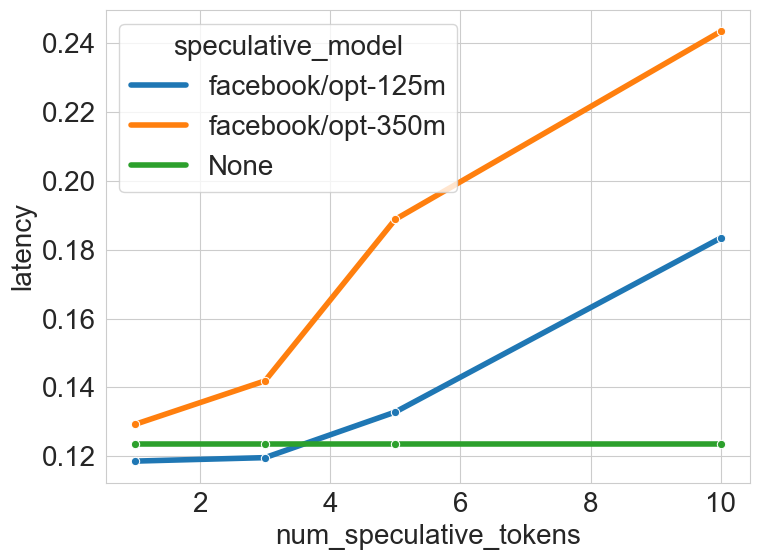

In [ ]:
fixed_params = {'num_requests': 32, 'batch_size': 1, 'GPU': 'A40'}
new_df = df[(df['speculative_model'] == 'None') | (df['speculative_model'] == 'facebook/opt-125m') | (df['speculative_model'] == 'facebook/opt-350m')]
plot_relationship(
    df=new_df,
    fixed_params=fixed_params,
    x_var='num_speculative_tokens',
    y_var='latency',
    hue_var='speculative_model',
    plot_type='line',
    # title='Latency vs. Number of Speculative Tokens'
)

fixed_params = {'num_requests': 32, 'batch_size': 4, 'GPU': 'A40'}
plot_relationship(
    df=new_df,
    fixed_params=fixed_params,
    x_var='num_speculative_tokens',
    y_var='latency',
    hue_var='speculative_model',
    plot_type='line',
    # title='Latency vs. Number of Speculative Tokens'
)

In [ ]:
def plot_heatmap(df, fixed_params, x_var, y_var, value_var, title=None):
    """
    Creates a heatmap for the value_var with x_var and y_var axes.

    Parameters:
    - df: The DataFrame containing the data.
    - fixed_params: Dictionary of variables to fix.
    - x_var: Variable for the x-axis.
    - y_var: Variable for the y-axis.
    - value_var: Variable to display in the heatmap.
    - title: Title of the plot (optional).
    """
    # Filter the DataFrame based on fixed_params
    df_filtered = df.copy()
    for key, value in fixed_params.items():
        df_filtered = df_filtered[df_filtered[key] == value]
    
    if df_filtered.empty:
        print("No data available for the given fixed parameters.")
        return
    
    # Create a pivot table
    pivot_table = df_filtered.pivot_table(index=y_var, columns=x_var, values=value_var)
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='YlGnBu')
    plt.title(title)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.tight_layout()
    plt.show()

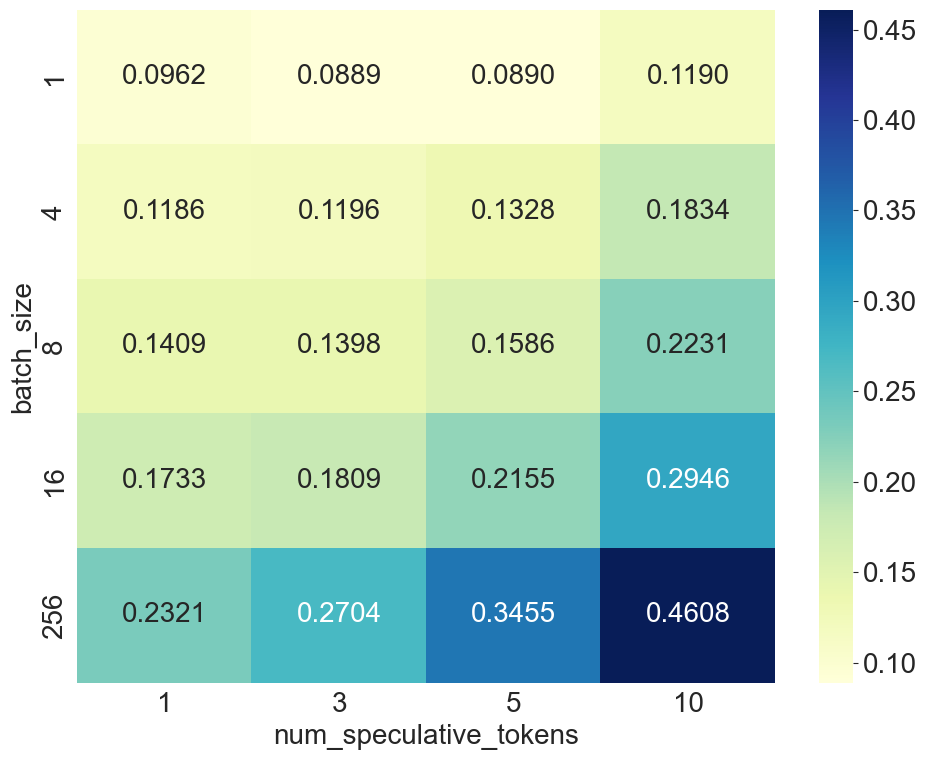

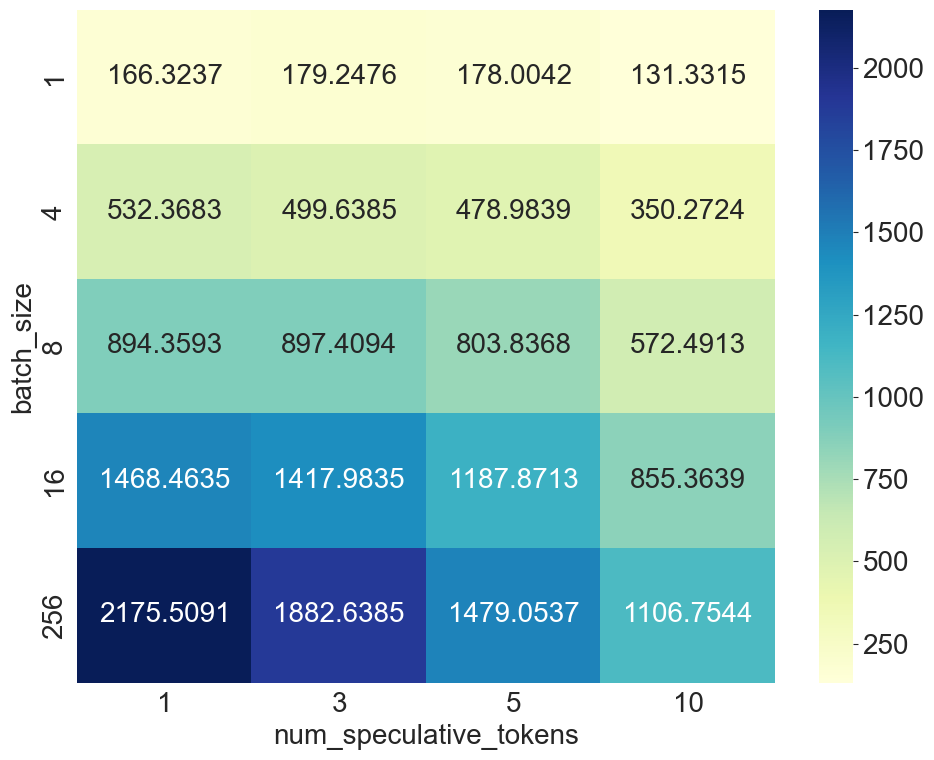

In [ ]:
fixed_params = {'num_requests': 32, 'GPU': 'A40', "speculative_model": "facebook/opt-125m"}
plot_heatmap(
    df=df,
    fixed_params=fixed_params,
    x_var='num_speculative_tokens',
    y_var='batch_size',
    value_var='latency', # latency   output_token_throughput  total_token_throughput  sequence_throughput
)

plot_heatmap(
    df=df,
    fixed_params=fixed_params,
    x_var='num_speculative_tokens',
    y_var='batch_size',
    value_var='output_token_throughput', # latency   output_token_throughput  total_token_throughput  sequence_throughput
)